In [1]:
'''
A Multilayer Perceptron implementation example using TensorFlow library.
This example is using the MNIST database of handwritten digits
(http://yann.lecun.com/exdb/mnist/)

Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

'\nA Multilayer Perceptron implementation example using TensorFlow library.\nThis example is using the MNIST database of handwritten digits\n(http://yann.lecun.com/exdb/mnist/)\n\nAuthor: Aymeric Damien\nProject: https://github.com/aymericdamien/TensorFlow-Examples/\n'

In [2]:
import tensorflow as tf
#import input_data
import os
import numpy as np
import cPickle as pickle
import util
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# LOAD DATA

In [30]:
# True if you don't want to use the test data and you just want to evaluate the model
# on the training data
testing = True

In [19]:
with open('X_train_bigram.pkl') as f:
    X_train = pickle.load(f).todense()
with open('t_train.pkl') as f:
    Y_train = pickle.load(f)
with open('X_test_bigram.pkl') as f:
    X_test = pickle.load(f).todense()
with open('test_ids.pkl') as f:
    test_ids = pickle.load(f)
    
nclass = 1 + Y_train.max()
Y_one_hot_train = np.eye(nclass)[Y_train]

In [31]:
if testing:
    train_data, test_data, train_label, test_label = train_test_split(X_train, Y_one_hot_train, test_size=0.20, random_state=42)  
else:
    train_data = X_train
    test_data = X_test
    train_label=Y_one_hot_train

In [32]:
ntrain = train_data.shape[0]
dim = train_data.shape[1]
ntest = test_data.shape[0]

In [33]:
print ("%d train images loaded" % (ntrain))
print ("%d test images loaded" % (ntest))
print ("%d dimensional input" % (dim))
print ("%d classes" % (nclass))

2468 train images loaded
618 test images loaded
2214 dimensional input
15 classes


# DEFINE NETWORK

In [37]:
tf.set_random_seed(0)
# Parameters
learning_rate   = 0.00001
training_epochs = 10000
batch_size      = ntrain
display_step    = 200

# Network Parameters
n_hidden_1 = 50 # 1st layer num features
n_input    = dim # data input 
n_classes  = nclass # total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

# Create model
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    return tf.matmul(layer_1, _weights['out']) + _biases['out']
    
# Store layers weight & bias
stddev = 0.1 # <== This greatly affects accuracy!! 
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
print ("Network Ready to Go!")

Network Ready to Go!


# DEFINE FUNCTIONS

In [38]:
# Construct model
pred = multilayer_perceptron(x, weights, biases)

final_pred = tf.argmax(pred,1)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= pred, labels = y)) 
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# Initializing the variables
init = tf.initialize_all_variables()
print ("Functions ready")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Functions ready


# OPTIMIZE

In [39]:
%%time
# Launch the graph
sess = tf.Session()
sess.run(init)

training_acc_list = []
test_acc_list = []
epoch_list = []

# Training cycle
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(ntrain/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        randidx = np.random.randint(ntrain, size=batch_size)
        batch_xs = train_data[randidx, :]
        batch_ys = train_label[randidx, :]   
        # Fit training using batch data
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
        # Compute average loss
        avg_cost += sess.run(cost, 
                feed_dict={x: batch_xs, y: batch_ys})/total_batch
        # Display logs per epoch step
        
        
    train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
    training_acc_list.append(train_acc)
    
    
    if testing:
            test_acc = sess.run(accr, feed_dict={x: test_data, y: test_label})
            test_acc_list.append(test_acc)
    epoch_list.append(epoch)
            
    if epoch % display_step == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % 
               (epoch, training_epochs, avg_cost))
        #train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
        print (" Training accuracy: %.3f" % (train_acc))
        if testing:
            #test_acc = sess.run(accr, feed_dict={x: test_data, y: test_label})
            print (" Test accuracy: %.3f" % (test_acc))
    if epoch == training_epochs - 1:       
        y_pred = sess.run(final_pred, feed_dict={x: test_data})
    
        
print ("Optimization Finished!")

Epoch: 000/10000 cost: 117.527160645
 Training accuracy: 0.011
 Test accuracy: 0.011
Epoch: 200/10000 cost: 106.654373169
 Training accuracy: 0.012
 Test accuracy: 0.011
Epoch: 400/10000 cost: 93.398155212
 Training accuracy: 0.015
 Test accuracy: 0.011
Epoch: 600/10000 cost: 78.892395020
 Training accuracy: 0.018
 Test accuracy: 0.015
Epoch: 800/10000 cost: 50.290767670
 Training accuracy: 0.019
 Test accuracy: 0.008
Epoch: 1000/10000 cost: 43.415115356
 Training accuracy: 0.021
 Test accuracy: 0.011
Epoch: 1200/10000 cost: 38.861412048
 Training accuracy: 0.022
 Test accuracy: 0.019
Epoch: 1400/10000 cost: 26.872074127
 Training accuracy: 0.091
 Test accuracy: 0.086
Epoch: 1600/10000 cost: 22.414150238
 Training accuracy: 0.468
 Test accuracy: 0.437
Epoch: 1800/10000 cost: 17.294162750
 Training accuracy: 0.486
 Test accuracy: 0.445
Epoch: 2000/10000 cost: 14.556947708
 Training accuracy: 0.467
 Test accuracy: 0.448
Epoch: 2200/10000 cost: 15.336621284
 Training accuracy: 0.500
 Test

In [29]:
if not testing:
    util.write_predictions(y_pred, test_ids, 'predictions_nn_bigram_features_25kepochs_eta00002.csv')

In [ ]:
np.asarray(test_acc_list).max()

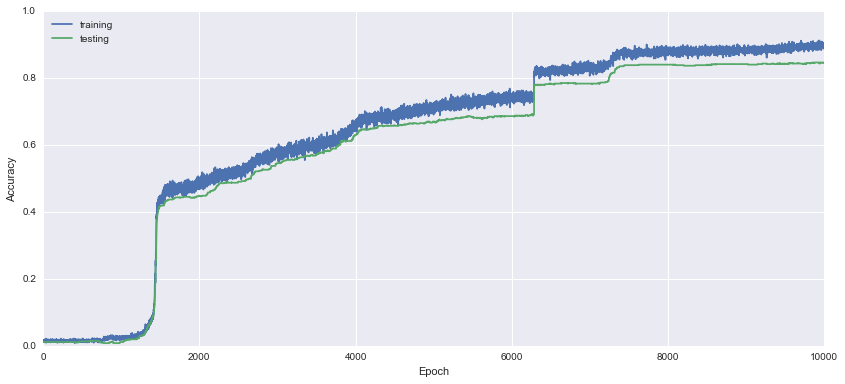

In [40]:
plt.figure(figsize=(14,6))
plt.plot(epoch_list, training_acc_list,label='training')
plt.plot(epoch_list, test_acc_list,label='testing')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [32]:
len(test_ids)

3724